In [1]:
import numpy as np
import scipy as sp
import os
import sys
import matplotlib.pyplot as plt
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
lgcg_path = os.path.abspath(os.path.join('../lazified_pdap'))
if lgcg_path not in sys.path:
    sys.path.append(lgcg_path)
from lib.measure import Measure
from lazified_pdap import LazifiedPDAP

# Heat Equation

## Generate Data and Define Functions

In [2]:
Omega = np.array([[0,1], [0,1]])
alpha = 1e-1
observation_resolution = 4
std_factor = 0.1
true_sources = np.array([[0.28, 0.71], [0.51,0.27], [0.71,0.53]])
true_weights = np.array([1,-0.7, 0.8])

In [3]:
observations = (np.array(np.meshgrid(
                    *(
                        np.linspace(bound[0], bound[1], observation_resolution+2)
                        for bound in Omega
                    ))
            ).reshape(len(Omega), -1).T)
observations = np.array([obs for obs in observations if all(obs!=0) and all(obs!=1)])

In [4]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    outer_factor = np.sqrt(std_factor*np.pi)**Omega.shape[0]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        columns.append(exponentiated)
    result = np.transpose(np.array(columns), axes=(1,0))/outer_factor # shape=(len(x), len(observations))
    return result

In [5]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [6]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [7]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    outer_factor = std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated = np.exp(norms) # (len(x),)
        gradient = diff * exponentiated.reshape(-1,1) # shape=(len(x),Omega.shape[0])
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2))/outer_factor # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [8]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    outer_factors = [-std_factor*np.sqrt(std_factor*np.pi)**Omega.shape[0]/2,std_factor**2*np.sqrt(std_factor*np.pi)**Omega.shape[0]/4]
    for point in observations:
        diff = point-x # (len(x), Omega.shape[0])
        norms = -np.square(np.linalg.norm(diff, axis=1))/std_factor # (len(x),)
        exponentiated_normed_1 = np.exp(norms)/outer_factors[0] # (len(x),)
        exponentiated_normed_2 = np.exp(norms)/outer_factors[1] # (len(x),)
        first_part = np.repeat(np.eye(Omega.shape[0])[np.newaxis,:],len(x),axis=0)*exponentiated_normed_1.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        second_part = np.einsum('ij,ik->ijk', diff, diff)*exponentiated_normed_2.reshape(-1,1,1) # shape=(len(x),Omega.shape[0],Omega.shape[0])
        hessians.append(first_part+second_part)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [9]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [10]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [11]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [12]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [13]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [14]:
a = np.arange(0,1,0.01)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(kappa(a.reshape(1,-1).T), axis=1)
    norm_kappa = max(vals)
elif Omega.shape[0] == 2:
    x, y = np.meshgrid(a,a)
    points = np.array(list(zip(x.flatten(), y.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals) # ||k([0.5,0.5])||
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(kappa(points), axis=1)
    norm_kappa = max(vals)
else:
    norm_kappa = 10
norm_kappa

6.264527262470839

In [15]:
a = np.arange(0,1,0.1)
if Omega.shape[0] == 1:
    vals = np.linalg.norm(grad_kappa(a.reshape(1,-1).T), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
elif Omega.shape[0] == 2:
    B, D = np.meshgrid(a,a)
    points = np.array(list(zip(B.flatten(), D.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
elif Omega.shape[0] == 3:
    x, y, z = np.meshgrid(a,a,a)
    points = np.array(list(zip(x.flatten(), y.flatten(), z.flatten())))
    vals = np.linalg.norm(grad_kappa(points), axis=(1,2))
    norm_kappa1 = max(norm_kappa, max(vals))
else:
    norm_kappa1 = 50
norm_kappa1

27.126794337315015

In [16]:
gamma = 0.5
theta = 1e-1
sigma = 2e-3
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-2
L_H

1.0

## Experiments

In [17]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           norm_kappa1=norm_kappa1,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R
           )

In [18]:
exp.M

259.0174619826847

### PDAP

In [18]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-15)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: Phi:3.290E+03, support: [[0.44043758 0.69141258]], coefs: [1.05279812], x: [0.42427898 0.23939056]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:2: Phi:1.586E+03, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141258]], coefs: [-0.46886794  1.23385151], x: [0.83741191 0.49779621]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:3: Phi:1.290E+03, support: [[0.42427898 0.23939056]
 [0.44043758 0.69141258]
 [0.83741191 0.49779621]], coefs: [-0.53679209  1.13760922  0.3139453 ], x: [0.14118912 0.63968789]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:4: Phi:3.331E+02, support: [[0.14118912 0.63968789

In [19]:
best = objective_values[-1]

In [20]:
np.array(times[:150])

array([2.38418579e-07, 5.34752607e-01, 1.02771330e+00, 1.49341369e+00,
       2.02996874e+00, 2.62485337e+00, 3.13761854e+00, 3.62187839e+00,
       4.10533738e+00, 4.65645051e+00, 5.18971181e+00, 5.75194788e+00,
       6.26757908e+00, 6.78780675e+00, 7.37143779e+00, 7.92475200e+00,
       8.49457884e+00, 8.96800900e+00, 9.45644450e+00, 9.96013975e+00,
       1.04429073e+01, 1.09630027e+01, 1.14564896e+01, 1.19135613e+01,
       1.24181485e+01, 1.29156919e+01, 1.34668224e+01, 1.39484153e+01,
       1.45632448e+01, 1.50530782e+01, 1.55668128e+01, 1.60441175e+01,
       1.65502911e+01, 1.70304401e+01, 1.75039871e+01, 1.80464144e+01,
       1.85464644e+01, 1.90402489e+01, 1.95145497e+01, 2.00156827e+01,
       2.05463784e+01, 2.10522478e+01, 2.15435846e+01, 2.20299437e+01,
       2.25082006e+01, 2.30151947e+01, 2.35913908e+01, 2.40875158e+01,
       2.46428580e+01, 2.51052413e+01, 2.56397183e+01, 2.61729460e+01,
       2.67123270e+01, 2.72215021e+01, 2.77926354e+01, 2.83713229e+01,
      

In [21]:
np.array(supports[:150])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9])

In [22]:
objective_values[:150]-best

array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698663e-02, 4.28609944e-02, 2.43456506e-02, 2.24655450e-02,
       2.19692477e-02, 1.97512431e-02, 1.45352926e-02, 1.17524225e-02,
       8.37236219e-03, 8.03803924e-03, 7.27480805e-03, 5.49766940e-03,
       4.74499601e-03, 4.33283626e-03, 3.06984423e-03, 3.03428444e-03,
       2.57014217e-03, 2.25412097e-03, 2.23311015e-03, 1.77761534e-03,
       1.74648392e-03, 1.02712747e-03, 1.00858178e-03, 7.05155587e-04,
       4.57693388e-04, 3.73211977e-04, 3.33190169e-04, 3.26992818e-04,
       3.19892471e-04, 2.76244554e-04, 2.23205519e-04, 2.02456251e-04,
       1.54179999e-04, 1.15910020e-04, 8.64004635e-05, 6.07039715e-05,
       5.67239423e-05, 4.57612933e-05, 4.45947156e-05, 4.10278346e-05,
       3.04747041e-05, 1.81648547e-05, 1.30623802e-05, 1.09291962e-05,
       1.01616338e-05, 9.32082142e-06, 8.04376061e-06, 5.27265804e-06,
      

In [23]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322726 0.71433132]
 [0.28322726 0.71433132]
 [0.28322726 0.71433132]
 [0.28322726 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322727 0.71433132]
 [0.28322728 0.71433131]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322728 0.71433132]
 [0.28322729 0.71433131]
 [0.28322729 0.71433132]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.49565837 0.23548621]
 [0.

### Newton

In [24]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot = exp.newton(tol=1e-12, damped=False, lgcg_frequency=5)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.05000000000000001, objective: 2.590E+01, dropped:False
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[0.44444444 0.68686869]], coefs: [0.24313342], epsilon: 0.05000000000000001, objective: 1.770E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[0.39580212 0.77166564]], coefs: [1.07721868], epsilon: 0.05000000000000001, objective: 5.294E+00
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[0.41739199 0.75205174]], coefs: [1.1253606], epsilon: 0.05000000000000001, objective: 5.130E+00
INFO:root:True, True, False, True, True
DEBUG:root:SSN in 1 dimensions converged in 1 iterations to tolerance 2.500E-04
INFO:root:2: choice: 2, lazy: True, support: [[0.41635812 0.75329279]], epsilon: 0.05000000000000001, objective: 5.129E+00, dropped:False
INFO:root:True, True, True, True, True
INFO:root:3, 1: lazy: True, support: [[0.41414141 0.2020202 ]
 [0.

In [25]:
dropped_tot

0

In [26]:
np.array(times)

array([2.38418579e-07, 5.12909889e-03, 1.73037052e-02, 2.35862732e-02,
       3.03430557e-02, 5.23843765e-02, 6.67619705e-02, 7.29839802e-02,
       7.96446800e-02, 8.59818459e-02, 9.92064476e-02, 1.18408203e-01,
       1.40538692e-01, 1.95311308e-01, 2.12137461e-01, 2.20052719e-01,
       7.79507637e-01, 1.31414843e+00, 1.82514787e+00, 1.84942913e+00,
       2.44652557e+00, 2.95061111e+00, 2.96478295e+00, 2.97175908e+00,
       3.49066639e+00, 3.63045025e+00, 4.11832738e+00])

In [27]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 5, 6, 6, 5, 6, 7, 6, 6, 7,
       4, 4, 3, 3, 3])

In [28]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5,  4.5],
       [ 5.5, 10.5],
       [13.5, 15.5],
       [21.5, 23.5],
       [24.5, 25.5]])

In [29]:
objective_values-best

array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 5.05470051e+00,
       4.89062393e+00, 4.89010890e+00, 4.34012717e+00, 2.57954034e+00,
       2.46278057e+00, 2.45311211e+00, 2.45047563e+00, 1.37210241e+00,
       2.25970925e-01, 9.46248236e-02, 9.35884195e-02, 3.21552724e-02,
       2.53237027e-03, 2.37351925e-03, 2.28676260e-03, 1.03192011e-03,
       7.17546127e-05, 6.70808351e-05, 7.01373085e-03, 2.91460001e-05,
       2.90654048e-09, 2.90654109e-09, 5.55111512e-17])

In [30]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

13
13
6
13


In [31]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[1.80411242e-15]
1.4710455076283324e-15


In [32]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([402.39077647, 272.29702466, 194.35314083,  68.45550373,
        48.27005118,   1.82700375,   7.42624618,  18.87504405,
        24.25981572])

### Newton Damped

In [33]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot = exp.newton(tol=1e-12, damped=True, damping_root=1)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.05000000000000001, objective: 2.590E+01, dropped:False
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[0.44444444 0.68686869]], coefs: [0.24313342], epsilon: 0.05000000000000001, objective: 1.770E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[0.4413723  0.69222429]], coefs: [0.29581252], epsilon: 0.05000000000000001, objective: 1.619E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[0.43916149 0.69630035]], coefs: [0.34656846], epsilon: 0.05000000000000001, objective: 1.484E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[0.43738316 0.69973295]], coefs: [0.39565904], epsilon: 0.05000000000000001, objective: 1.362E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[0.43585617 0.70279706]], coefs: [0.44316896], epsilon: 0.05000000000000001, objective: 1.251E+01
INFO:root:Tru

In [34]:
dropped_tot

0

In [35]:
np.array(times)

array([2.38418579e-07, 6.84285164e-03, 1.79865360e-02, 2.42786407e-02,
       3.06906700e-02, 3.68089676e-02, 4.77221012e-02, 5.37743568e-02,
       6.02073669e-02, 6.60812855e-02, 7.24272728e-02, 8.30199718e-02,
       9.07037258e-02, 9.66935158e-02, 1.02949619e-01, 1.09250069e-01,
       1.20315790e-01, 1.26490116e-01, 1.32336378e-01, 1.39846087e-01,
       1.46014690e-01, 1.56517506e-01, 1.62743092e-01, 1.68859243e-01,
       1.75260782e-01, 1.81868076e-01, 1.92008734e-01, 1.98341131e-01,
       2.04180002e-01, 2.11122513e-01, 2.16839075e-01, 2.27505922e-01,
       2.33717442e-01, 2.40455151e-01, 2.46502399e-01, 2.62965918e-01,
       2.77218580e-01, 2.83901215e-01, 2.90648460e-01, 2.97079802e-01,
       3.10580015e-01, 3.17098856e-01, 3.24497461e-01, 3.31586838e-01,
       3.37671757e-01, 3.51877213e-01, 3.59220982e-01, 3.66916418e-01,
       3.74661922e-01, 3.82806301e-01, 3.96735907e-01, 4.03361797e-01,
       4.09991741e-01, 4.16547775e-01, 4.22817469e-01, 4.36625004e-01,
      

In [36]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [37]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5, 34.5],
       [35.5, 58.5],
       [61.5, 72.5]])

In [38]:
objective_values-best

array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 1.59556125e+01,
       1.46006495e+01, 1.33776930e+01, 1.22753761e+01, 1.12845081e+01,
       1.03968791e+01, 9.60485702e+00, 8.90122927e+00, 8.27913165e+00,
       7.73201400e+00, 7.25362160e+00, 6.83798438e+00, 6.47940999e+00,
       6.17247893e+00, 5.91204096e+00, 5.69321212e+00, 5.51137241e+00,
       5.36216392e+00, 5.24148950e+00, 5.14551215e+00, 5.07065532e+00,
       5.01360428e+00, 4.97130886e+00, 4.94098782e+00, 4.92013480e+00,
       4.90652602e+00, 4.89822905e+00, 4.89361191e+00, 4.89135099e+00,
       4.89043497e+00, 4.89016059e+00, 4.89011206e+00, 3.13259275e+00,
       2.73039295e+00, 2.11989567e+00, 1.72060471e+00, 1.40539010e+00,
       1.14583499e+00, 9.29851543e-01, 7.49695470e-01, 5.99717572e-01,
       4.75444893e-01, 3.73142908e-01, 2.89592405e-01, 2.21969734e-01,
       1.67779467e-01, 1.24815174e-01, 9.11363231e-02, 6.50549364e-02,
       4.51275036e-02, 3.01473182e-02, 1.91309838e-02, 1.12922891e-02,
      

In [39]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

17
17
2
6


In [40]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.28322727 0.71433132]
 [0.49565837 0.23548621]
 [0.73058833 0.54790134]] and coefficients [ 0.99569143 -0.6175807   0.71213226]
[5.17641485e-15]
7.216449660063518e-15


### LPDAP

In [41]:
u, Phi_ks, times, supports, objective_values, dropped_tot = exp.lpdap(tol=1e-12)

INFO:root:38.166405330163634
INFO:root:1: Step: GCG, Lazy True, Phi_k: 9.886E+03, epsilon: 5.000E-02, support: [], coefs: [], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:1.4477454899700963
INFO:root:1.4477454899700963
INFO:root:2: Step: GCG, Lazy True, Phi_k: 3.750E+02, epsilon: 5.000E-02, support: [[0.44444444 0.68686869]], coefs: [1.04692849], dropped:False
INFO:root:==============================================
INFO:root:dropped 1 points
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:11.459461132145742
INFO:root:-0.0005722613399066628
INFO:root:3: Step: GCG, Lazy True, Phi_k: 2.968E+03, epsilon: 5.000E-02, support: [[0.44444444 0.68686869]
 [0.53099843 0.8475285 ]], coefs: [0.81869591 0.30439042], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations t

In [42]:
dropped_tot

18

In [43]:
np.array(times)

array([5.39517403e-03, 2.35917568e-02, 4.62970734e-02, 6.33332729e-02,
       8.78467560e-02, 1.06956244e-01, 1.24434471e-01, 1.43955469e-01,
       1.63506985e-01, 1.82270288e-01, 2.00168848e-01, 2.24765539e-01,
       2.50473022e-01, 2.73791552e-01, 2.98393965e-01, 3.25556040e-01,
       8.57103586e-01, 8.77006531e-01, 8.97455692e-01, 9.16522741e-01,
       9.34863806e-01, 1.47334814e+00, 1.49025536e+00, 1.50966454e+00,
       1.53450012e+00, 2.07225919e+00, 2.08763266e+00, 2.10369587e+00,
       2.12259150e+00, 2.73768544e+00, 2.75806642e+00, 2.77912283e+00,
       2.79536295e+00, 2.81864095e+00, 2.83517146e+00, 3.41986585e+00,
       3.43928266e+00, 3.45641232e+00, 3.47507048e+00, 4.04399490e+00,
       4.06544542e+00, 4.08709478e+00, 4.10305333e+00, 4.11844468e+00,
       4.13541842e+00, 4.15287805e+00, 4.74463916e+00, 4.76115966e+00,
       4.77573228e+00, 5.29158926e+00, 5.30478239e+00, 5.92620015e+00,
       5.93979430e+00, 5.95421958e+00, 5.97143316e+00, 5.98555064e+00,
      

In [44]:
np.array(supports)

array([ 0,  1,  2,  3,  3,  4,  5,  6,  6,  7,  7,  8,  8,  6,  7,  8,  9,
        8,  8,  8,  9,  9,  9,  9,  8,  9,  8,  7,  8,  7,  7,  7,  8,  8,
        8,  9,  9,  9,  8,  9,  7,  7,  8,  9,  9,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9, 10,  9,  8,  8,  9,  9,  9,  9, 10,  9,
        7,  7,  7,  8,  7,  8,  7,  8,  8,  8,  8,  9,  8, 10,  8,  9, 10,
        8,  8, 11,  8,  9,  8,  9,  7,  7,  8,  8, 10,  9,  9,  9,  9, 10,
       10,  9, 10, 11,  9, 12, 12,  8,  9, 12, 12,  8,  8, 10,  9, 10, 11,
       10,  9, 10, 10, 10, 10, 10, 10,  9,  8,  8,  9, 11, 14, 12, 11, 11,
       12,  8, 10,  9, 11, 14, 13, 11, 13, 15, 16, 18])

In [45]:
objective_values-best

array([2.56626430e+01, 5.68389440e+00, 5.46356874e+00, 2.51910533e+00,
       2.49298190e+00, 1.52469495e+00, 1.33945182e+00, 1.29802107e+00,
       8.46074075e-01, 5.13466689e-01, 4.14884846e-01, 3.91024806e-01,
       1.55155636e-01, 3.95412394e-02, 3.13866741e-02, 2.94766324e-02,
       2.82051904e-02, 2.28593408e-02, 1.96871575e-02, 1.86096627e-02,
       1.70658782e-02, 1.07842586e-02, 7.21612798e-03, 6.90793044e-03,
       4.05933706e-03, 4.03971512e-03, 3.83848109e-03, 2.63342936e-03,
       2.55200721e-03, 2.05861827e-03, 1.62405479e-03, 1.06209667e-03,
       1.02888502e-03, 1.01907670e-03, 6.35384696e-04, 5.59209273e-04,
       4.51283409e-04, 3.19493169e-04, 1.95737661e-04, 1.94554157e-04,
       1.67967282e-04, 1.61962695e-04, 1.61085470e-04, 1.58185351e-04,
       1.53864046e-04, 1.25822544e-04, 6.05812245e-05, 4.79051341e-05,
       4.46606779e-05, 3.37597835e-05, 3.22982405e-05, 2.57161838e-05,
       1.95509331e-05, 1.76499504e-05, 1.37312726e-05, 1.26401627e-05,
      

In [46]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[0.2832272  0.71433132]
 [0.2832272  0.7143313 ]
 [0.28322725 0.71433135]
 [0.28322725 0.71433135]
 [0.28322725 0.71433135]
 [0.2832273  0.71433138]
 [0.28322741 0.71433132]
 [0.49565829 0.23548623]
 [0.49565834 0.23548622]
 [0.49565838 0.23548624]
 [0.49565838 0.23548617]
 [0.73058826 0.5479014 ]
 [0.73058827 0.5479014 ]
 [0.73058827 0.5479014 ]
 [0.73058827 0.5479014 ]
 [0.73058834 0.54790132]
 [0.73058834 0.54790133]
 [0.73058835 0.54790133]] and coefficients [ 0.40040127  0.20313582  0.01787189  0.02017051  0.01548799  0.03574225
  0.3028817  -0.00151311 -0.0647622  -0.30411233 -0.24719307  0.03849824
  0.02985907  0.01065096  0.03024022  0.25589276  0.17949013  0.1675009 ]
[4.24660307e-15]
3.969047313034935e-15


## Plots

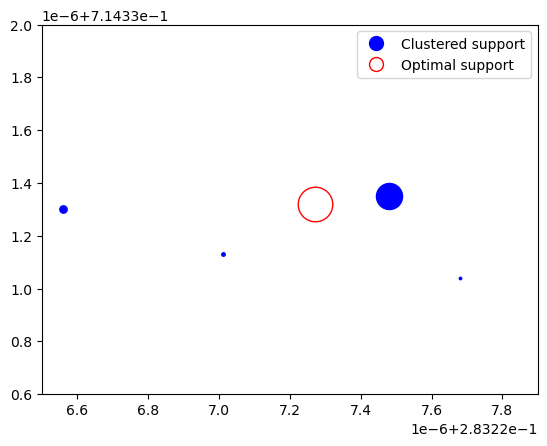

In [73]:
clustered_points = [[0.28322656, 0.7143313 ], [0.28322701, 0.71433113], [0.28322748, 0.71433135], [0.28322768, 0.71433104]]
clustered_weights = [0.21149885,  0.1,  0.75096038, 0.07]
true_point = [0.28322727, 0.71433132]
true_weight = 0.99569143
plt.plot(0,0,"o", c="b", markersize=10,label="Clustered support"); # Point for legend
plt.plot(0,0,"o", c="r", fillstyle="none", markersize=10,label="Optimal support"); # Point for legend
for (x,c) in zip(clustered_points, clustered_weights):
    plt.plot(x[0], x[1], "o", c="b", markersize=25*c);
plt.plot(true_point[0], true_point[1], "o", fillstyle="none", c="r", markersize=25*true_weight);
plt.ylim(7.143313e-1-7e-7, 7.143313e-1+7e-7)
plt.xlim(2.832272e-1-7e-7, 2.832272e-1+7e-7)
plt.legend(fontsize=10);

DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f7e6eb964a0>


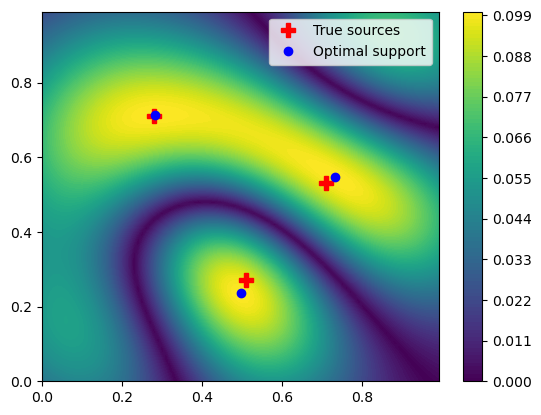

In [160]:
u_tilde = u #Measure(support=[[0.16189578,0.67106819],[0.22222222,0.77777778],[0.33333333,0.66666667],[0.33333333,0.77777778],[0.44444444,0.22222222],[0.44444444,0.33333333],[0.5129322,0.21945235],[0.66666667,0.55555556],[0.77777778,0.44444444],[0.77777778,0.55555556],[0.88888889,0.88888889]], coefficients=[0.12089905,0.30391103,0.5035049,0.13645795,-0.11020099,-0.09355168,-0.43700644,0.23772164,0.05493194,0.41683878,-0.00129572])
P = lambda x: np.abs(p(u_tilde)(x))
a = np.arange(0,1,0.01)
B, D = np.meshgrid(a,a)
vals = np.array([P(np.array([x_1,x_2])) for x_1, x_2 in zip(B.flatten(), D.flatten())]).reshape((100,100))

plt.contourf(B, D, vals, levels=100);
plt.colorbar();
for i, x in enumerate(true_sources):
    if i:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10);
    else:
        plt.plot([x[0]], [x[1]], "P", c="r", markersize=10, label="True sources");
for i, x in enumerate(u_tilde.support):
    if i:
        plt.plot([x[0]], [x[1]], "o", c="b");
    else:
        plt.plot([x[0]], [x[1]], "o", c="b", label="Optimal support");
plt.legend();

In [ ]:
residuals_pdap = np.array([2.56626430e+01, 5.56767886e+00, 2.59016866e+00, 1.62903637e+00,
       2.29592885e-01, 1.29111896e-01, 6.02585416e-02, 5.81289511e-02,
       5.43698663e-02, 4.28609944e-02, 2.43456506e-02, 2.24655450e-02,
       2.19692477e-02, 1.97512431e-02, 1.45352926e-02, 1.17524225e-02,
       8.37236219e-03, 8.03803924e-03, 7.27480805e-03, 5.49766940e-03,
       4.74499601e-03, 4.33283626e-03, 3.06984423e-03, 3.03428444e-03,
       2.57014217e-03, 2.25412097e-03, 2.23311015e-03, 1.77761534e-03,
       1.74648392e-03, 1.02712747e-03, 1.00858178e-03, 7.05155587e-04,
       4.57693388e-04, 3.73211977e-04, 3.33190169e-04, 3.26992818e-04,
       3.19892471e-04, 2.76244554e-04, 2.23205519e-04, 2.02456251e-04,
       1.54179999e-04, 1.15910020e-04, 8.64004635e-05, 6.07039715e-05,
       5.67239423e-05, 4.57612933e-05, 4.45947156e-05, 4.10278346e-05,
       3.04747041e-05, 1.81648547e-05, 1.30623802e-05, 1.09291962e-05,
       1.01616338e-05, 9.32082142e-06, 8.04376061e-06, 5.27265804e-06,
       4.24350107e-06, 3.14343763e-06, 2.27059930e-06, 2.09985738e-06,
       1.54896073e-06, 1.32282125e-06, 1.21863744e-06, 7.01233291e-07,
       5.11486213e-07, 4.95514209e-07, 2.81617283e-07, 2.65567772e-07,
       2.43879425e-07, 2.04779400e-07, 1.51890929e-07, 1.42716880e-07,
       1.19812768e-07, 1.02445860e-07, 8.55149948e-08, 6.41045845e-08,
       4.00090297e-08, 2.96556866e-08, 2.79020514e-08, 2.69369677e-08,
       1.81602914e-08, 1.71166687e-08, 1.21881429e-08, 1.17864418e-08,
       1.04790152e-08, 9.05217001e-09, 4.49363399e-09, 3.01657610e-09,
       2.25290089e-09, 2.06415984e-09, 1.99861044e-09, 1.73256401e-09,
       1.58690397e-09, 1.27681066e-09, 7.37284039e-10, 6.21192930e-10,
       4.89527224e-10, 4.03469952e-10, 3.88580834e-10, 3.23770066e-10,
       2.21344443e-10, 1.92941468e-10, 1.74567971e-10, 1.35846112e-10,
       1.18579840e-10, 1.17384130e-10, 1.12501536e-10, 7.33523242e-11,
       5.95699601e-11, 4.00990630e-11, 2.89484825e-11, 2.78619905e-11,
       2.63095379e-11, 2.39352704e-11, 1.88708216e-11, 1.02573783e-11,
       3.57003316e-12, 3.34451911e-12, 2.91833224e-12, 2.88571944e-12,
       1.97855621e-12, 1.42741374e-12, 1.16195942e-12, 1.14599996e-12,
       9.89985871e-13, 8.88233931e-13, 8.23174862e-13, 7.93393129e-13,
       7.37215844e-13, 4.39509540e-13, 4.05314671e-13, 2.72865064e-13,
       2.56128452e-13, 2.25180985e-13, 2.16937579e-13, 1.61953784e-13,
       1.40804035e-13, 1.12160281e-13, 7.33857419e-14, 6.96942504e-14,
       5.86197757e-14, 4.24382751e-14, 3.43891582e-14, 3.00037772e-14,
       2.40640841e-14, 1.97064587e-14, 1.93456362e-14, 1.50990331e-14,
       1.02973186e-14, 5.85642645e-15])

times_pdap = np.array([2.38418579e-07, 5.34752607e-01, 1.02771330e+00, 1.49341369e+00,
       2.02996874e+00, 2.62485337e+00, 3.13761854e+00, 3.62187839e+00,
       4.10533738e+00, 4.65645051e+00, 5.18971181e+00, 5.75194788e+00,
       6.26757908e+00, 6.78780675e+00, 7.37143779e+00, 7.92475200e+00,
       8.49457884e+00, 8.96800900e+00, 9.45644450e+00, 9.96013975e+00,
       1.04429073e+01, 1.09630027e+01, 1.14564896e+01, 1.19135613e+01,
       1.24181485e+01, 1.29156919e+01, 1.34668224e+01, 1.39484153e+01,
       1.45632448e+01, 1.50530782e+01, 1.55668128e+01, 1.60441175e+01,
       1.65502911e+01, 1.70304401e+01, 1.75039871e+01, 1.80464144e+01,
       1.85464644e+01, 1.90402489e+01, 1.95145497e+01, 2.00156827e+01,
       2.05463784e+01, 2.10522478e+01, 2.15435846e+01, 2.20299437e+01,
       2.25082006e+01, 2.30151947e+01, 2.35913908e+01, 2.40875158e+01,
       2.46428580e+01, 2.51052413e+01, 2.56397183e+01, 2.61729460e+01,
       2.67123270e+01, 2.72215021e+01, 2.77926354e+01, 2.83713229e+01,
       2.89003778e+01, 2.95440052e+01, 3.02099304e+01, 3.08009839e+01,
       3.12846177e+01, 3.17849650e+01, 3.22967749e+01, 3.27755017e+01,
       3.32602241e+01, 3.37439511e+01, 3.42978024e+01, 3.48699088e+01,
       3.54677007e+01, 3.59684348e+01, 3.64678993e+01, 3.70431325e+01,
       3.76039495e+01, 3.80920222e+01, 3.85872624e+01, 3.90591860e+01,
       3.95405242e+01, 4.00410879e+01, 4.05184052e+01, 4.10696599e+01,
       4.15594966e+01, 4.20728836e+01, 4.25627904e+01, 4.31044354e+01,
       4.36270170e+01, 4.41418047e+01, 4.46568217e+01, 4.52315361e+01,
       4.57190161e+01, 4.62365799e+01, 4.67595081e+01, 4.72476499e+01,
       4.77240329e+01, 4.82104707e+01, 4.87012463e+01, 4.92386644e+01,
       4.97321455e+01, 5.02140510e+01, 5.07486966e+01, 5.12418001e+01,
       5.17154095e+01, 5.22149975e+01, 5.27272289e+01, 5.33158188e+01,
       5.39023101e+01, 5.44430075e+01, 5.49618442e+01, 5.55189800e+01,
       5.60738556e+01, 5.65415564e+01, 5.70823405e+01, 5.75740466e+01,
       5.80476816e+01, 5.85553555e+01, 5.90446897e+01, 5.95292892e+01,
       6.00636508e+01, 6.06187549e+01, 6.11871529e+01, 6.16899927e+01,
       6.23728654e+01, 6.30348794e+01, 6.36466687e+01, 6.41669483e+01,
       6.47364707e+01, 6.53308427e+01, 6.58947613e+01, 6.64281237e+01,
       6.69631917e+01, 6.74515009e+01, 6.79425852e+01, 6.84491973e+01,
       6.90151453e+01, 6.95516827e+01, 7.00575035e+01, 7.05727394e+01,
       7.12022567e+01, 7.16916080e+01, 7.22232542e+01, 7.27475982e+01,
       7.32423215e+01, 7.37214422e+01, 7.42499657e+01, 7.47415311e+01,
       7.52436957e+01, 7.57519395e+01, 7.62422752e+01, 7.67424269e+01,
       7.72514365e+01, 7.77773030e+01])

supports_pdap = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 8, 9, 9, 9, 8, 8, 9, 9, 9, 9, 9,
       8, 9, 8, 8, 9, 8, 9, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9,
       8, 8, 8, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 8, 9, 9, 8, 8,
       8, 8, 9, 9, 8, 8, 7, 8, 8, 8, 7, 7, 7, 7, 8, 8, 8, 9, 9, 9, 9, 9,
       9, 8, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 9, 8, 9, 9])

residuals_newton = np.array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 5.05470051e+00,
       4.89062393e+00, 4.89010890e+00, 4.34012717e+00, 2.57954034e+00,
       2.46278057e+00, 2.45311211e+00, 2.45047563e+00, 1.37210241e+00,
       2.25970925e-01, 9.46248236e-02, 9.35884195e-02, 3.21552724e-02,
       2.53237027e-03, 2.37351925e-03, 2.28676260e-03, 1.03192011e-03,
       7.17546127e-05, 6.70808351e-05, 7.01373085e-03, 2.91460001e-05,
       2.90654048e-09, 2.90654109e-09, 5.55111512e-17])

times_newton = np.array([2.38418579e-07, 5.12909889e-03, 1.73037052e-02, 2.35862732e-02,
       3.03430557e-02, 5.23843765e-02, 6.67619705e-02, 7.29839802e-02,
       7.96446800e-02, 8.59818459e-02, 9.92064476e-02, 1.18408203e-01,
       1.40538692e-01, 1.95311308e-01, 2.12137461e-01, 2.20052719e-01,
       7.79507637e-01, 1.31414843e+00, 1.82514787e+00, 1.84942913e+00,
       2.44652557e+00, 2.95061111e+00, 2.96478295e+00, 2.97175908e+00,
       3.49066639e+00, 3.63045025e+00, 4.11832738e+00])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 4, 5, 6, 6, 5, 6, 7, 6, 6, 7,
       4, 4, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  4.5],
       [ 5.5, 10.5],
       [13.5, 15.5],
       [21.5, 23.5],
       [24.5, 25.5]])

residuals_newton_damped = np.array([2.56626430e+01, 2.56626430e+01, 1.74606299e+01, 1.59556125e+01,
       1.46006495e+01, 1.33776930e+01, 1.22753761e+01, 1.12845081e+01,
       1.03968791e+01, 9.60485702e+00, 8.90122927e+00, 8.27913165e+00,
       7.73201400e+00, 7.25362160e+00, 6.83798438e+00, 6.47940999e+00,
       6.17247893e+00, 5.91204096e+00, 5.69321212e+00, 5.51137241e+00,
       5.36216392e+00, 5.24148950e+00, 5.14551215e+00, 5.07065532e+00,
       5.01360428e+00, 4.97130886e+00, 4.94098782e+00, 4.92013480e+00,
       4.90652602e+00, 4.89822905e+00, 4.89361191e+00, 4.89135099e+00,
       4.89043497e+00, 4.89016059e+00, 4.89011206e+00, 3.13259275e+00,
       2.73039295e+00, 2.11989567e+00, 1.72060471e+00, 1.40539010e+00,
       1.14583499e+00, 9.29851543e-01, 7.49695470e-01, 5.99717572e-01,
       4.75444893e-01, 3.73142908e-01, 2.89592405e-01, 2.21969734e-01,
       1.67779467e-01, 1.24815174e-01, 9.11363231e-02, 6.50549364e-02,
       4.51275036e-02, 3.01473182e-02, 1.91309838e-02, 1.12922891e-02,
       5.99940138e-03, 2.71838994e-03, 9.55220665e-04, 1.68619127e-05,
       1.64040502e-05, 3.31479508e-07, 4.51515376e-03, 2.59542089e-03,
       1.38103304e-03, 6.62858940e-04, 2.75846533e-04, 9.32742530e-05,
       2.28242669e-05, 3.21104956e-06, 1.54953146e-07, 7.32979899e-10,
       2.14273044e-14, 2.77555756e-17])

times_newton_damped = np.array([2.38418579e-07, 6.84285164e-03, 1.79865360e-02, 2.42786407e-02,
       3.06906700e-02, 3.68089676e-02, 4.77221012e-02, 5.37743568e-02,
       6.02073669e-02, 6.60812855e-02, 7.24272728e-02, 8.30199718e-02,
       9.07037258e-02, 9.66935158e-02, 1.02949619e-01, 1.09250069e-01,
       1.20315790e-01, 1.26490116e-01, 1.32336378e-01, 1.39846087e-01,
       1.46014690e-01, 1.56517506e-01, 1.62743092e-01, 1.68859243e-01,
       1.75260782e-01, 1.81868076e-01, 1.92008734e-01, 1.98341131e-01,
       2.04180002e-01, 2.11122513e-01, 2.16839075e-01, 2.27505922e-01,
       2.33717442e-01, 2.40455151e-01, 2.46502399e-01, 2.62965918e-01,
       2.77218580e-01, 2.83901215e-01, 2.90648460e-01, 2.97079802e-01,
       3.10580015e-01, 3.17098856e-01, 3.24497461e-01, 3.31586838e-01,
       3.37671757e-01, 3.51877213e-01, 3.59220982e-01, 3.66916418e-01,
       3.74661922e-01, 3.82806301e-01, 3.96735907e-01, 4.03361797e-01,
       4.09991741e-01, 4.16547775e-01, 4.22817469e-01, 4.36625004e-01,
       4.43108797e-01, 4.49883223e-01, 4.56140995e-01, 1.00105453e+00,
       1.54363370e+00, 2.02808499e+00, 2.04134130e+00, 2.04784322e+00,
       2.05449200e+00, 2.06212258e+00, 2.07410002e+00, 2.07909083e+00,
       2.08423591e+00, 2.08954096e+00, 2.09451842e+00, 2.10607910e+00,
       2.11139035e+00, 2.69358253e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5, 34.5],
       [35.5, 58.5],
       [61.5, 72.5]])

residuals_lpdap = np.array([2.56626430e+01, 5.68389440e+00, 5.46356874e+00, 2.51910533e+00,
       2.49298190e+00, 1.52469495e+00, 1.33945182e+00, 1.29802107e+00,
       8.46074075e-01, 5.13466689e-01, 4.14884846e-01, 3.91024806e-01,
       1.55155636e-01, 3.95412394e-02, 3.13866741e-02, 2.94766324e-02,
       2.82051904e-02, 2.28593408e-02, 1.96871575e-02, 1.86096627e-02,
       1.70658782e-02, 1.07842586e-02, 7.21612798e-03, 6.90793044e-03,
       4.05933706e-03, 4.03971512e-03, 3.83848109e-03, 2.63342936e-03,
       2.55200721e-03, 2.05861827e-03, 1.62405479e-03, 1.06209667e-03,
       1.02888502e-03, 1.01907670e-03, 6.35384696e-04, 5.59209273e-04,
       4.51283409e-04, 3.19493169e-04, 1.95737661e-04, 1.94554157e-04,
       1.67967282e-04, 1.61962695e-04, 1.61085470e-04, 1.58185351e-04,
       1.53864046e-04, 1.25822544e-04, 6.05812245e-05, 4.79051341e-05,
       4.46606779e-05, 3.37597835e-05, 3.22982405e-05, 2.57161838e-05,
       1.95509331e-05, 1.76499504e-05, 1.37312726e-05, 1.26401627e-05,
       1.01365544e-05, 9.33713056e-06, 9.06389869e-06, 6.59596474e-06,
       5.27425566e-06, 4.09121331e-06, 4.00866912e-06, 3.80560589e-06,
       2.55260664e-06, 2.42483363e-06, 2.36119395e-06, 1.95786340e-06,
       1.24836307e-06, 7.17530344e-07, 5.41667720e-07, 5.28624267e-07,
       5.13331970e-07, 4.08560930e-07, 3.43340423e-07, 3.36985847e-07,
       2.64613407e-07, 1.44924134e-07, 1.40752914e-07, 1.37190413e-07,
       1.15823444e-07, 4.87627969e-08, 3.67635401e-08, 3.53730142e-08,
       3.38074919e-08, 3.12392238e-08, 2.37598367e-08, 2.29402732e-08,
       1.03845371e-08, 1.00395377e-08, 7.29068259e-09, 6.25497376e-09,
       6.11985104e-09, 4.47098150e-09, 2.29433514e-09, 2.20705987e-09,
       1.37296979e-09, 1.12046775e-09, 7.64546926e-10, 6.11373896e-10,
       5.72999648e-10, 5.35570421e-10, 4.76700845e-10, 4.22297086e-10,
       2.57377480e-10, 2.42197401e-10, 1.84114418e-10, 1.84114418e-10,
       1.84114418e-10, 7.38938355e-11, 4.04387079e-11, 4.04386802e-11,
       4.04386802e-11, 1.97371841e-11, 1.28530520e-11, 1.00709163e-11,
       8.82038886e-12, 4.57608951e-12, 3.61929930e-12, 3.54949403e-12,
       2.00800487e-12, 7.81791298e-13, 7.69245778e-13, 7.64110997e-13,
       7.64194263e-13, 5.59607916e-13, 5.25385291e-13, 5.15310017e-13,
       4.77007323e-13, 2.24265051e-13, 1.89015470e-13, 1.66061609e-13,
       1.63563607e-13, 1.36335387e-13, 5.99242878e-14, 5.83144644e-14,
       4.84334794e-14, 3.31401573e-14, 2.68673972e-14, 2.44526621e-14,
       2.31481501e-14, 1.69309011e-14, 1.12410081e-14, 5.88418203e-15,
       5.24580379e-15, 5.21804822e-15, 5.27355937e-15, 4.38538095e-15])

times_lpdap = np.array([5.39517403e-03, 2.35917568e-02, 4.62970734e-02, 6.33332729e-02,
       8.78467560e-02, 1.06956244e-01, 1.24434471e-01, 1.43955469e-01,
       1.63506985e-01, 1.82270288e-01, 2.00168848e-01, 2.24765539e-01,
       2.50473022e-01, 2.73791552e-01, 2.98393965e-01, 3.25556040e-01,
       8.57103586e-01, 8.77006531e-01, 8.97455692e-01, 9.16522741e-01,
       9.34863806e-01, 1.47334814e+00, 1.49025536e+00, 1.50966454e+00,
       1.53450012e+00, 2.07225919e+00, 2.08763266e+00, 2.10369587e+00,
       2.12259150e+00, 2.73768544e+00, 2.75806642e+00, 2.77912283e+00,
       2.79536295e+00, 2.81864095e+00, 2.83517146e+00, 3.41986585e+00,
       3.43928266e+00, 3.45641232e+00, 3.47507048e+00, 4.04399490e+00,
       4.06544542e+00, 4.08709478e+00, 4.10305333e+00, 4.11844468e+00,
       4.13541842e+00, 4.15287805e+00, 4.74463916e+00, 4.76115966e+00,
       4.77573228e+00, 5.29158926e+00, 5.30478239e+00, 5.92620015e+00,
       5.93979430e+00, 5.95421958e+00, 5.97143316e+00, 5.98555064e+00,
       6.62998390e+00, 6.64517093e+00, 6.65779877e+00, 6.66974187e+00,
       6.68531752e+00, 7.32748628e+00, 7.34164858e+00, 7.35323048e+00,
       7.36864090e+00, 7.38391423e+00, 7.95482635e+00, 8.49981308e+00,
       8.51405001e+00, 8.52965856e+00, 9.18541813e+00, 9.20028591e+00,
       9.21210122e+00, 9.22612309e+00, 9.23892069e+00, 9.25246477e+00,
       9.76320434e+00, 9.77789783e+00, 9.79011989e+00, 9.80328321e+00,
       9.81513524e+00, 1.03852468e+01, 1.08607645e+01, 1.13491819e+01,
       1.13619721e+01, 1.13741293e+01, 1.19469309e+01, 1.19605942e+01,
       1.19754696e+01, 1.19888558e+01, 1.20008497e+01, 1.25370157e+01,
       1.29929395e+01, 1.30039904e+01, 1.34956877e+01, 1.35074365e+01,
       1.40450788e+01, 1.45640731e+01, 1.45792422e+01, 1.45960066e+01,
       1.46100788e+01, 1.46253691e+01, 1.51784685e+01, 1.56874948e+01,
       1.57050171e+01, 1.57171884e+01, 1.62874992e+01, 1.67945130e+01,
       1.72646725e+01, 1.77553356e+01, 1.77723241e+01, 1.83165734e+01,
       1.87818623e+01, 1.88022790e+01, 1.92879479e+01, 1.97683275e+01,
       1.97818480e+01, 2.02840106e+01, 2.02972522e+01, 2.03134844e+01,
       2.03305035e+01, 2.08707635e+01, 2.13439031e+01, 2.13590288e+01,
       2.13714731e+01, 2.13877330e+01, 2.14051931e+01, 2.19655738e+01,
       2.25174420e+01, 2.25418155e+01, 2.25590281e+01, 2.30757847e+01,
       2.30865064e+01, 2.31015606e+01, 2.36445987e+01, 2.42278948e+01,
       2.42461283e+01, 2.42759352e+01, 2.48202662e+01, 2.48337951e+01,
       2.48463886e+01, 2.53736651e+01, 2.59182861e+01, 2.59405196e+01,
       2.59531543e+01, 2.59693894e+01, 2.59853973e+01, 2.65565674e+01])

supports_lpdap = np.array([ 0,  1,  2,  3,  3,  4,  5,  6,  6,  7,  7,  8,  8,  6,  7,  8,  9,
        8,  8,  8,  9,  9,  9,  9,  8,  9,  8,  7,  8,  7,  7,  7,  8,  8,
        8,  9,  9,  9,  8,  9,  7,  7,  8,  9,  9,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  9,  9,  9, 10,  9,  8,  8,  9,  9,  9,  9, 10,  9,
        7,  7,  7,  8,  7,  8,  7,  8,  8,  8,  8,  9,  8, 10,  8,  9, 10,
        8,  8, 11,  8,  9,  8,  9,  7,  7,  8,  8, 10,  9,  9,  9,  9, 10,
       10,  9, 10, 11,  9, 12, 12,  8,  9, 12, 12,  8,  8, 10,  9, 10, 11,
       10,  9, 10, 10, 10, 10, 10, 10,  9,  8,  8,  9, 11, 14, 12, 11, 11,
       12,  8, 10,  9, 11, 14, 13, 11, 13, 15, 16, 18])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-14, 30);
# plt.xlim(0, 135);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-14, 30);
# plt.xlim(0, 60);
plt.legend();

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton);
for interval in intervals_newton:
    plt.fill_between(interval, 0, 30, color='green', alpha=0.25);
plt.ylim(1e-12, 30);
plt.xlabel("Total iterations");

# Signal Processing

## Generate Data and Define Functions

In [47]:
observation_resolution = 120
Omega = np.array([[0,observation_resolution//2]])
alpha = 1e-1
true_sources = np.array([[3.125], [7], [np.sqrt(179)]])
true_weights = np.array([-1, 0.7, 0.5])

In [48]:
observations = np.arange(0,1,1/observation_resolution)

In [49]:
def kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    columns = []
    for t in observations:
        column = np.sin(2*np.pi*x*t).flatten()
        columns.append(column)
    result = np.transpose(np.array(columns), axes=(1,0)) # shape=(len(x), len(observations))
    return result

In [50]:
u_hat = Measure(support=true_sources, coefficients=true_weights)
target = u_hat.duality_pairing(kappa)

In [51]:
g = lambda u: alpha * np.linalg.norm(u, ord=1)
f = lambda u: 0.5 * np.linalg.norm(u.duality_pairing(kappa) - target) ** 2

In [52]:
def grad_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    gradients = []
    for t in observations:
        factor = 2*np.pi*t
        column = np.cos(2*np.pi*x*t) # (len(x), Omega.shape[0])
        gradient = factor * column
        gradients.append(gradient)
    result = np.transpose(np.array(gradients), axes=(1,0,2)) # The Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0])
    return result

In [53]:
def hess_kappa(x):
    # Input is 2D array of shape (number of points, Omega dimension)
    if len(x.shape) == 1:
        x = x.reshape(1, -1)
    hessians = []
    for t in observations:
        factor = -4*np.pi**2*t**2
        column = np.sin(2*np.pi*x*t).reshape(-1,1,1) # (len(x), Omega.shape[0], Omega.shape[0])
        hessian = factor * column
        hessians.append(hessian)
    result = np.transpose(np.array(hessians), axes=(1,0,2,3)) # The derivative of the Jacobian of kappa, shape=(len(x), len(observations), Omega.shape[0], Omega.shape[0])
    return result

In [54]:
def p_raw(u):
    Ku = u.duality_pairing(kappa)
    inner = Ku-target
    return lambda x: -kappa(x) @ inner

p = lambda u: p_raw(u)

In [55]:
def grad_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1)*np.tensordot(grad_kappa(x), inner, axes=([1,0]))

grad_P = lambda u: grad_P_raw(u)

In [56]:
def hess_P_raw(u):
    p_u = p_raw(u)
    inner = target-u.duality_pairing(kappa)
    return lambda x: np.sign(p_u(x)).reshape(-1,1,1)*np.tensordot(hess_kappa(x),inner,axes=([1,0]))

hess_P = lambda u: hess_P_raw(u)

In [57]:
def grad_j(positions, coefs):
    K_matrix = kappa(positions)
    grad_F = (K_matrix.T@coefs).flatten() - target
    nabla_x = coefs.reshape(-1,1)*np.tensordot(grad_kappa(positions), grad_F, axes=([1,0]))
    nabla_u = np.dot(K_matrix, grad_F) + alpha * np.sign(coefs)
    return np.append(nabla_x.flatten(), nabla_u, axis=0).flatten()

In [58]:
def hess_j(positions, coefs):
    kappa_values = kappa(positions)
    grad_kappa_values = grad_kappa(positions)
    hess_kappa_values = hess_kappa(positions)
    matrix_dimension = len(positions)*Omega.shape[0] + len(coefs)
    hesse_matrix = np.zeros((matrix_dimension, matrix_dimension))
    step = Omega.shape[0]
    coefs_delay = step*len(positions)
    inner = (kappa_values.T@coefs).flatten() - target
    for i in range(len(positions)):
        # nabla_{x_i,x_j}
        for j in range(len(positions)):
            if j<i:
                continue
            block = coefs[i]*coefs[j]*np.matmul(grad_kappa_values[i].T, grad_kappa_values[j])
            if i==j:
                block += coefs[i]*np.tensordot(hess_kappa_values[i],inner,axes=([0,0]))
            hesse_matrix[i*step:(i+1)*step, j*step:(j+1)*step] = block
            hesse_matrix[j*step:(j+1)*step, i*step:(i+1)*step] = block.T
        # nabla_{x_i,u_j}
        for j in range(len(coefs)):
            block = coefs[i]*np.matmul(grad_kappa_values[i].T, kappa_values[j])
            if i == j:
                block += np.matmul(grad_kappa_values[i].T, inner)
            hesse_matrix[i*step:(i+1)*step, coefs_delay+j] = block
            hesse_matrix[coefs_delay+j, i*step:(i+1)*step] = block.T
    for i in range(len(coefs)):
        # nabla_{u_i,u_j}
        for j in range(len(coefs)):
            if j<i:
                continue
            block = np.dot(kappa_values[i], kappa_values[j])
            hesse_matrix[coefs_delay+i,coefs_delay+j] = block
            hesse_matrix[coefs_delay+j,coefs_delay+i] = block
    return hesse_matrix

In [59]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(kappa(a), axis=1)
norm_kappa = max(vals)
norm_kappa

8.436705235037092

In [60]:
a = np.arange(Omega[0][0], Omega[0][1], 0.1).reshape(-1,1)
vals = np.linalg.norm(grad_kappa(a), axis=(1,2))
norm_kappa1 = max(norm_kappa, max(vals))
norm_kappa1

39.48990157632303

In [61]:
gamma = 0.5
theta = 1e-1
sigma = 5e-2
m = 1e-3
bar_m = 1e-1
L = 1
L_H = max(np.abs(true_weights))
R = 1e-1
L_H

1.0

## Experiments

In [62]:
exp = LazifiedPDAP(target=target, 
           kappa=kappa, 
           g=g, 
           f=f,
           p=p,
           grad_P=grad_P,
           hess_P=hess_P,
           norm_kappa=norm_kappa,
           norm_kappa1=norm_kappa1,
           grad_j=grad_j,
           hess_j=hess_j,
           alpha=alpha,
           Omega=Omega,
           gamma=gamma,
           theta=theta,
           sigma=sigma,
           m=m,
           bar_m=bar_m,
           L=L,
           L_H=L_H,
           R=R,
           M=50
           )

### PDAP

In [64]:
u, P_values, times, supports, objective_values = exp.pdap(tol=1e-13)

DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:1: Phi:2.102E+03, support: [[3.13588856]], coefs: [-1.02219696], x: [7.00005078]
INFO:root:==============================================
DEBUG:root:SSN in 2 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:2: Phi:1.497E+03, support: [[3.13588856]
 [7.00005078]], coefs: [-0.99145093  0.70208178], x: [13.38203765]
INFO:root:==============================================
DEBUG:root:SSN in 3 dimensions converged in 3 iterations to tolerance 1.000E-12
INFO:root:3: Phi:9.018E+01, support: [[ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.99785308  0.69586351  0.49867157], x: [2.81555416]
INFO:root:==============================================
DEBUG:root:SSN in 4 dimensions converged in 2 iterations to tolerance 1.000E-12
INFO:root:4: Phi:3.918E+01, support: [[ 2.81555416]
 [ 3.13588856]
 [ 7.00005078]
 [13.38203765]], coefs: [-0.03816109 -0.97952737  0.69852898  0.49805815

In [65]:
best = objective_values[-1]
best

0.2197538626001281

In [66]:
np.array(times[:70])

array([4.76837158e-07, 1.04078770e-01, 1.74919367e-01, 2.46320486e-01,
       3.21677685e-01, 3.96261454e-01, 4.64334965e-01, 5.32457352e-01,
       5.97367525e-01, 6.71969891e-01, 7.39107370e-01, 8.13725233e-01,
       8.82116556e-01, 9.53030586e-01, 1.04348326e+00, 1.12142944e+00,
       1.21218896e+00, 1.28142333e+00, 1.35655761e+00, 1.42971110e+00,
       1.51615548e+00, 1.59043264e+00, 1.65706015e+00, 1.73137808e+00,
       1.82206059e+00, 1.91323638e+00, 2.00360847e+00, 2.08821797e+00,
       2.16489029e+00, 2.25826502e+00, 2.33751583e+00, 2.42071033e+00,
       2.49452376e+00, 2.56687546e+00, 2.65238070e+00, 2.72597003e+00,
       2.81793809e+00, 2.90220404e+00, 2.97154069e+00, 3.04265022e+00,
       3.11146975e+00, 3.18280101e+00, 3.26079226e+00, 3.33022881e+00,
       3.39887476e+00, 3.46805239e+00, 3.53621101e+00, 3.60871696e+00,
       3.67875123e+00, 3.74999285e+00, 3.83049703e+00, 3.92246771e+00,
       4.00399685e+00, 4.09677768e+00, 4.18859220e+00, 4.26368594e+00,
      

In [67]:
np.array(supports[:70])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6])

In [68]:
objective_values[:70]-best

array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239775e-02, 8.58376252e-03, 6.60215205e-03, 6.26160457e-03,
       5.81056957e-03, 5.68714554e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625307e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583831e-04, 3.70010641e-04, 3.28227689e-04, 3.27716481e-04,
       1.08225418e-04, 8.89059417e-05, 8.85996713e-05, 2.08581055e-05,
       1.15859896e-05, 1.14112380e-05, 8.58446562e-06, 4.06824488e-06,
       3.96465445e-06, 2.55842288e-06, 1.39500359e-06, 1.33895639e-06,
       6.37729845e-07, 3.72191365e-07, 3.43278988e-07, 1.86417488e-07,
       1.07770631e-07, 9.30291451e-08, 4.47906126e-08, 3.13019586e-08,
       2.38731729e-08, 1.63321581e-08, 9.87044438e-09, 6.13792947e-09,
       2.36218306e-09, 2.29294589e-09, 4.22666513e-10, 3.32070621e-10,
       2.96450947e-10, 1.96910321e-10, 1.51273355e-10, 1.33152378e-10,
       8.30928937e-11, 6.01859673e-11, 5.10477494e-11, 2.59457178e-11,
      

In [69]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502169]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502177]
 [ 3.12502184]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999252]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999257]
 [ 6.99999264]
 [13.37905646]
 [13.37905646]
 [13.37905646]
 [13.37905647]
 [13.37905647]
 [13.37905647]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905652]
 [13.37905653]
 [13.37905653]
 [13.3790566 ]] and coefficients [-6.89131579e-01 -1.17955969e-02 -1.40167925e-02 -9.89651048e-03
 -1.85719056e-02 -1.25798711e-02 -1.07661405e-03 -2.03044158e-02
 -1.07376356e-02 -2.29676144e-02 -1.87248742e-01  1.35305736e-02
  5.86089397e-02  5.31554647e-02  3.41449537e-02  7.37017986e-03
  8.27745783e-03  7.20393971e-03  1.98668374e-02  3.37583560e-03
  1.00067894e-02  1.46007272e-02  1.71288548e-02  1

### Newton

In [70]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot = exp.newton(tol=1e-12, damped=False)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.5291269403006611, objective: 5.291E+01, dropped:False
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[3.10517529]], coefs: [-0.20775711], epsilon: 0.5291269403006611, objective: 4.188E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[3.27164622]], coefs: [-1.08547986], epsilon: 0.5291269403006611, objective: 3.112E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[3.05511777]], coefs: [-1.30703184], epsilon: 0.5291269403006611, objective: 2.871E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[3.12602412]], coefs: [-1.06623658], epsilon: 0.5291269403006611, objective: 2.260E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[3.13547144]], coefs: [-1.02299012], epsilon: 0.5291269403006611, objective: 2.250E+01
INFO:root:True, True, False, True, True
INFO:root:dropped 1 points
DE

In [71]:
dropped_tot

1

In [72]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.09029774e+01,
        2.84925698e+01,  2.23790151e+01,  2.22758082e+01,  7.51520858e+00,
        4.77281182e+00,  7.72924321e-02,  3.75464937e-01,  2.59752249e-03,
        1.40443125e-03,  1.82277977e-04,  8.01635083e-04,  7.62753150e-09,
       -4.41313652e-15])

In [73]:
np.array(times)

array([4.76837158e-07, 6.16955757e-03, 3.38172913e-02, 4.81395721e-02,
       5.75625896e-02, 6.78846836e-02, 8.13360214e-02, 1.04807138e-01,
       1.23737812e-01, 1.48341656e-01, 1.67264938e-01, 2.78647900e-01,
       3.10422182e-01, 4.39314127e-01, 4.58475590e-01, 4.77790833e-01,
       6.89519405e-01])

In [74]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 3, 3, 3])

In [75]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5,  6.5],
       [ 7.5,  8.5],
       [ 9.5, 10.5],
       [13.5, 15.5]])

In [76]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

7
7
4
7


In [77]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[3.74700271e-15]
4.773959005888173e-15


In [78]:
print(np.linalg.norm(np.array([x[0] for x in u.support]) - np.array([x[0] for x in true_sources])))
print(np.linalg.norm(u.coefficients-true_weights))

3.911190177122026e-05
0.0028429187726321443


In [79]:
hess = hess_j(u.support, u.coefficients)
np.linalg.eig(hess).eigenvalues

array([841.50400003, 377.40347866, 187.63319262,  56.17717494,
        61.42436526,  60.16886452])

### Newton Damped

In [80]:
u, times, supports, inner_loop, inner_lazy, inner_total, outer_lazy, outer_total, objective_values, dropped_tot = exp.newton(tol=1e-12, damped=True, damping_root=1)

INFO:root:1: choice: 0, lazy: True, support: [], epsilon: 0.5291269403006611, objective: 5.291E+01, dropped:False
INFO:root:True, True, True, True, True
INFO:root:2, 1: lazy: True, support: [[3.10517529]], coefs: [-0.20775711], epsilon: 0.5291269403006611, objective: 4.188E+01
INFO:root:True, True, True, True, True
INFO:root:2, 2: lazy: N/A, support: [[3.11351583]], coefs: [-0.25173285], epsilon: 0.5291269403006611, objective: 3.983E+01
INFO:root:True, True, True, True, True
INFO:root:2, 3: lazy: N/A, support: [[3.11847898]], coefs: [-0.2926916], epsilon: 0.5291269403006611, objective: 3.802E+01
INFO:root:True, True, True, True, True
INFO:root:2, 4: lazy: N/A, support: [[3.12184754]], coefs: [-0.33188294], epsilon: 0.5291269403006611, objective: 3.639E+01
INFO:root:True, True, True, True, True
INFO:root:2, 5: lazy: True, support: [[3.12429631]], coefs: [-0.36968854], epsilon: 0.5291269403006611, objective: 3.491E+01
INFO:root:True, True, True, True, True
INFO:root:2, 6: lazy: N/A, supp

In [81]:
dropped_tot

0

In [82]:
objective_values-best

array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.96065862e+01,
        3.78034581e+01,  3.61744035e+01,  3.46903068e+01,  3.33352483e+01,
        3.20982247e+01,  3.09704677e+01,  2.99443907e+01,  2.90131204e+01,
        2.81702685e+01,  2.74098124e+01,  2.67260291e+01,  2.61134569e+01,
        2.55668730e+01,  2.50812785e+01,  2.46518900e+01,  2.42741327e+01,
        2.39436371e+01,  2.36562353e+01,  2.34079599e+01,  2.31950415e+01,
        2.30139082e+01,  2.28611842e+01,  2.27336895e+01,  2.26284386e+01,
        2.25426402e+01,  2.24736967e+01,  2.24192029e+01,  2.23769461e+01,
        2.23449045e+01,  2.23212469e+01,  2.23043313e+01,  2.22927039e+01,
        2.22850971e+01,  2.22804279e+01,  2.22777952e+01,  2.22764757e+01,
        2.22759193e+01,  7.51965812e+00,  4.77697568e+00,  4.05889828e+00,
        3.48568204e+00,  2.98872994e+00,  2.55188018e+00,  2.16708748e+00,
        1.82880914e+00,  1.53255007e+00,  1.27436574e+00,  1.05066214e+00,
        8.58105568e-01,  

In [83]:
np.array(times)

array([2.38418579e-07, 4.04548645e-03, 2.19409466e-02, 3.47528458e-02,
       4.68380451e-02, 5.90820312e-02, 7.55670071e-02, 9.14111137e-02,
       1.09308958e-01, 1.23284340e-01, 1.36635542e-01, 1.53027534e-01,
       1.64988995e-01, 1.75290585e-01, 1.87233686e-01, 1.99288368e-01,
       2.24098682e-01, 2.37183809e-01, 2.50626087e-01, 2.67910480e-01,
       2.81863689e-01, 3.00777435e-01, 3.13191175e-01, 3.25233936e-01,
       3.40722322e-01, 3.53800297e-01, 3.71867180e-01, 3.82521152e-01,
       3.95835876e-01, 4.07612324e-01, 4.19165373e-01, 4.37159777e-01,
       4.49653864e-01, 4.61997509e-01, 4.73258734e-01, 4.83802795e-01,
       4.99006748e-01, 5.11675835e-01, 5.22228479e-01, 5.34900427e-01,
       5.51598787e-01, 5.85014105e-01, 6.04682446e-01, 6.16948128e-01,
       6.30412340e-01, 6.43309593e-01, 6.67736769e-01, 6.81887150e-01,
       6.94635868e-01, 7.04308987e-01, 7.17139244e-01, 7.38703251e-01,
       7.54817247e-01, 7.67261028e-01, 7.79965162e-01, 7.93849945e-01,
      

In [84]:
np.array(supports)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [85]:
intervals = []
current_inner = False
for ind, i in enumerate(inner_loop):
    if i:
        if not current_inner:
            start = ind-0.5
            current_inner = True
    else:
        if current_inner:
            end = ind-0.5
            intervals.append((start,end))
            current_inner = False
np.array(intervals)

array([[ 1.5, 40.5],
       [41.5, 72.5],
       [73.5, 75.5]])

In [86]:
print(inner_lazy)
print(inner_total)
print(outer_lazy)
print(outer_total)

16
17
2
4


In [87]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502173]
 [ 6.9999926 ]
 [13.37905649]] and coefficients [-0.99832728  0.69841291  0.49833707]
[2.10942375e-15]
2.8033131371785203e-15


### LPDAP

In [88]:
u, Phi_ks, times, supports, objective_values, dropped_tot = exp.lpdap(tol=1e-12)

INFO:root:59.15093744613173
INFO:root:1: Step: GCG, Lazy True, Phi_k: 2.958E+03, epsilon: 5.291E-01, support: [], coefs: [], dropped:False
INFO:root:==============================================
DEBUG:root:SSN in 1 dimensions converged in 3 iterations to tolerance 5.000E-04
INFO:root:2.266794327166448
INFO:root:2.266794327166448
INFO:root:2: Step: GCG, Lazy True, Phi_k: 1.133E+02, epsilon: 5.291E-01, support: [[3.10517529]], coefs: [-1.01399371], dropped:False
INFO:root:==============================================
INFO:root:dropped 1 points
DEBUG:root:SSN in 2 dimensions converged in 2 iterations to tolerance 5.000E-04
INFO:root:3.0377310982621553
INFO:root:3.037731098262154
INFO:root:3: Step: GCG, Lazy True, Phi_k: 1.519E+02, epsilon: 5.291E-01, support: [[3.10517529]
 [4.33089484]], coefs: [-1.00948126 -0.03796282], dropped:False
INFO:root:==============================================
INFO:root:dropped 1 points
DEBUG:root:SSN in 3 dimensions converged in 2 iterations to tolerance

In [89]:
dropped_tot

1

In [90]:
np.array(times)

array([3.51953506e-03, 3.93528938e-02, 6.87630177e-02, 9.87083912e-02,
       1.34715796e-01, 1.69746637e-01, 2.02028036e-01, 2.25926161e-01,
       2.52076864e-01, 2.79445171e-01, 3.05338144e-01, 3.32345963e-01,
       3.57357979e-01, 3.82309675e-01, 4.12205219e-01, 4.53968048e-01,
       4.94141340e-01, 5.33160686e-01, 5.75845957e-01, 6.19061947e-01,
       6.63961411e-01, 7.02484846e-01, 7.47753382e-01, 8.71598244e-01,
       9.10273314e-01, 9.44583178e-01, 9.81917143e-01, 1.02458286e+00,
       1.06779981e+00, 1.19414949e+00, 1.23703218e+00, 1.28280783e+00,
       1.31518507e+00, 1.34732938e+00, 1.45675278e+00, 1.49424553e+00,
       1.53042960e+00, 1.57366681e+00, 1.60687017e+00, 1.65034342e+00,
       1.68674302e+00, 1.72952557e+00, 1.85710835e+00, 1.89741325e+00,
       1.93770266e+00, 1.97616601e+00, 2.01595426e+00, 2.05216670e+00,
       2.09437823e+00, 2.13037014e+00, 2.23958945e+00, 2.27624679e+00,
       2.30368280e+00, 2.32902026e+00, 2.36158705e+00, 2.47505689e+00,
      

In [91]:
np.array(supports)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 13, 13, 14,
       14, 15, 14, 13, 14, 14, 15, 16, 17, 17, 17, 18, 18, 18, 17, 18, 19,
       20, 21, 21, 21, 21, 20, 21, 22, 23, 23, 23, 23, 20, 19, 20, 20, 21,
       18, 18, 18, 14, 14, 14, 11, 12, 10,  7,  6,  6,  6,  6,  6,  6,  7,
        6,  6,  7,  6,  6,  7,  6,  7,  6,  7,  6,  6,  7,  6,  7,  6,  6,
        7,  6,  7,  6,  7,  8,  7,  6,  8,  7,  8,  7,  6,  8,  7, 10,  9,
        7,  8,  6,  8,  8,  6,  7,  6,  6,  6,  7,  6,  6,  6,  7,  6,  6,
        7,  6,  6,  6,  6,  7,  7, 10])

In [92]:
objective_values-best

array([5.26929402e+01, 2.27036009e+01, 2.26605773e+01, 2.25806762e+01,
       2.23448181e+01, 2.21862100e+01, 2.20597114e+01, 2.19901639e+01,
       2.18877061e+01, 2.17743791e+01, 2.16118717e+01, 2.10100773e+01,
       2.09378369e+01, 2.08786858e+01, 2.08550724e+01, 7.28295925e+00,
       7.27376811e+00, 7.25614491e+00, 7.15466903e+00, 2.09473897e-01,
       1.99133326e-01, 1.01597808e-01, 4.29350743e-02, 3.53646290e-02,
       3.42984958e-02, 3.40671544e-02, 3.21746868e-02, 3.15620274e-02,
       3.05766475e-02, 2.79618883e-02, 2.77340112e-02, 2.09507102e-02,
       2.08395471e-02, 2.07440164e-02, 2.06842113e-02, 2.06355294e-02,
       2.00077486e-02, 1.88552333e-02, 1.70489452e-02, 1.16911932e-02,
       1.15875831e-02, 1.15698234e-02, 1.15319473e-02, 1.15197142e-02,
       1.15079027e-02, 1.14831636e-02, 7.82946224e-03, 7.68826538e-03,
       7.67469329e-03, 7.66468166e-03, 7.66036737e-03, 6.39028810e-03,
       6.34459927e-03, 6.34141647e-03, 3.92570408e-03, 3.89173622e-03,
      

In [93]:
print(u)
print(max([abs(abs(p(u)(x))-alpha) for x in u.support]))
print(g(u.coefficients)-u.duality_pairing(p(u)))

Measure with support [[ 3.12502158]
 [ 3.12502183]
 [ 3.125022  ]
 [ 6.99999251]
 [ 6.99999273]
 [ 6.99999282]
 [ 6.99999297]
 [13.37905641]
 [13.37905658]
 [13.37905674]] and coefficients [-0.62175041 -0.06311628 -0.31346059  0.47376811  0.07243667  0.15082036
  0.00138777  0.34845756  0.04115659  0.10872292]
[2.50632848e-14]
2.5146551507759796e-14


## Plots

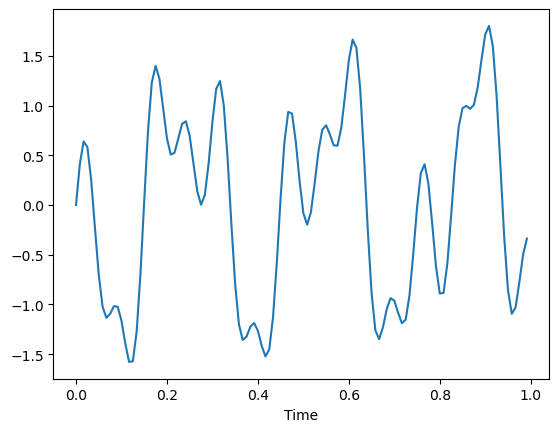

In [119]:
plt.plot(observations, target);
plt.xlabel("Time");

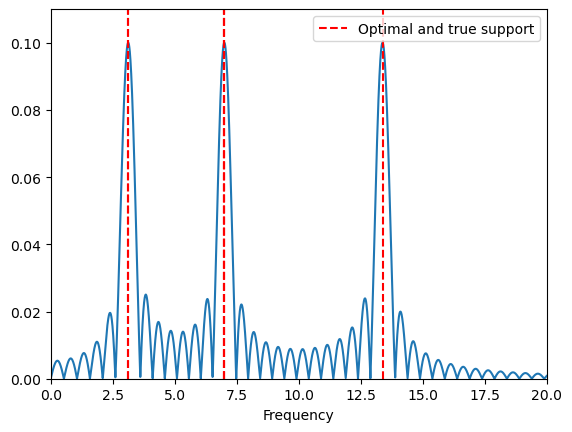

In [130]:
u_tilde = u # Measure(support=[[1.00840336],[1.51260504],[2.01680672],[2.5210084],[3.02521008],[3.52941176],[4.03361345],[4.53781513],[5.04201681],[6.52828034],[7.05882353],[7.56302521],[8.06722689],[8.57142857],[9.07563025],[9.57983193],[10.08403361],[10.58823529],[11.09243697],[11.59663866],[12.10084034],[12.60504202],[13.1092437],[13.61344538],[14.11764706],[14.62184874]], coefficients=[-0.02073555,0.03750054,-0.06643334,0.13918181,-0.92346277,-0.23878818,0.10786171,-0.06783396,0.04578576,0.04158428,0.72923855,-0.11325314,0.07786523,-0.06503374,0.05884924,-0.05590312,0.05517159,-0.05649383,0.06033915,-0.06817023,0.08409641,-0.123255,0.3144845,0.31918172,-0.08787151,0.04497542])
a = np.arange(Omega[0][0],Omega[0][1],0.005)
vals = np.array([np.abs(p(u_tilde)(np.array([x]))) for x in a])
plt.plot(a,vals);
for i, pos in enumerate(u_tilde.support):
    if not i:
        plt.axvline(x=pos, linestyle="--", c="r", label="Optimal and true support");
    else:
        plt.axvline(x=pos, linestyle="--", c="r");
plt.xlabel("Frequency");
plt.ylim(0,0.11);
plt.xlim(0, 20);
plt.legend();

In [ ]:
residuals_pdap = np.array([5.26929402e+01, 2.22757014e+01, 7.51575796e+00, 4.94388053e-02,
       1.50239775e-02, 8.58376252e-03, 6.60215205e-03, 6.26160457e-03,
       5.81056957e-03, 5.68714554e-03, 5.63453913e-03, 2.74798167e-03,
       2.49625307e-03, 2.43692854e-03, 1.09428955e-03, 1.06241337e-03,
       9.64583831e-04, 3.70010641e-04, 3.28227689e-04, 3.27716481e-04,
       1.08225418e-04, 8.89059417e-05, 8.85996713e-05, 2.08581055e-05,
       1.15859896e-05, 1.14112380e-05, 8.58446562e-06, 4.06824488e-06,
       3.96465445e-06, 2.55842288e-06, 1.39500359e-06, 1.33895639e-06,
       6.37729845e-07, 3.72191365e-07, 3.43278988e-07, 1.86417488e-07,
       1.07770631e-07, 9.30291451e-08, 4.47906126e-08, 3.13019586e-08,
       2.38731729e-08, 1.63321581e-08, 9.87044438e-09, 6.13792947e-09,
       2.36218306e-09, 2.29294589e-09, 4.22666513e-10, 3.32070621e-10,
       2.96450947e-10, 1.96910321e-10, 1.51273355e-10, 1.33152378e-10,
       8.30928937e-11, 6.01859673e-11, 5.10477494e-11, 2.59457178e-11,
       1.44746715e-11, 9.88614746e-12, 6.27364827e-12, 4.28321267e-12,
       3.35237393e-12, 1.54171120e-12, 6.05404615e-13, 2.65676370e-13,
       1.60566005e-13, 1.45883305e-13, 1.14630527e-13, 6.17839113e-14,
       5.43731726e-14, 3.87467836e-14])

times_pdap = np.array([4.76837158e-07, 1.04078770e-01, 1.74919367e-01, 2.46320486e-01,
       3.21677685e-01, 3.96261454e-01, 4.64334965e-01, 5.32457352e-01,
       5.97367525e-01, 6.71969891e-01, 7.39107370e-01, 8.13725233e-01,
       8.82116556e-01, 9.53030586e-01, 1.04348326e+00, 1.12142944e+00,
       1.21218896e+00, 1.28142333e+00, 1.35655761e+00, 1.42971110e+00,
       1.51615548e+00, 1.59043264e+00, 1.65706015e+00, 1.73137808e+00,
       1.82206059e+00, 1.91323638e+00, 2.00360847e+00, 2.08821797e+00,
       2.16489029e+00, 2.25826502e+00, 2.33751583e+00, 2.42071033e+00,
       2.49452376e+00, 2.56687546e+00, 2.65238070e+00, 2.72597003e+00,
       2.81793809e+00, 2.90220404e+00, 2.97154069e+00, 3.04265022e+00,
       3.11146975e+00, 3.18280101e+00, 3.26079226e+00, 3.33022881e+00,
       3.39887476e+00, 3.46805239e+00, 3.53621101e+00, 3.60871696e+00,
       3.67875123e+00, 3.74999285e+00, 3.83049703e+00, 3.92246771e+00,
       4.00399685e+00, 4.09677768e+00, 4.18859220e+00, 4.26368594e+00,
       4.32801604e+00, 4.42001343e+00, 4.49875307e+00, 4.57552314e+00,
       4.64230585e+00, 4.71323204e+00, 4.78030896e+00, 4.86549497e+00,
       4.93134069e+00, 5.02153969e+00, 5.09716749e+00, 5.18865204e+00,
       5.25816560e+00, 5.35074806e+00])

supports_pdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  9,  9,  8,  7,  7,  7,
        5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6])

residuals_newton = np.array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.09029774e+01,
        2.84925698e+01,  2.23790151e+01,  2.22758082e+01,  7.51520858e+00,
        4.77281182e+00,  7.72924321e-02,  3.75464937e-01,  2.59752249e-03,
        1.40443125e-03,  1.82277977e-04,  8.01635083e-04,  7.62753150e-09,
       -4.41313652e-15])

times_newton = np.array([4.76837158e-07, 6.16955757e-03, 3.38172913e-02, 4.81395721e-02,
       5.75625896e-02, 6.78846836e-02, 8.13360214e-02, 1.04807138e-01,
       1.23737812e-01, 1.48341656e-01, 1.67264938e-01, 2.78647900e-01,
       3.10422182e-01, 4.39314127e-01, 4.58475590e-01, 4.77790833e-01,
       6.89519405e-01])

supports_newton = np.array([0, 0, 1, 1, 1, 1, 1, 2, 3, 4, 4, 4, 4, 4, 3, 3, 3])

intervals_newton = np.array([[ 1.5,  6.5],
       [ 7.5,  8.5],
       [ 9.5, 10.5],
       [13.5, 15.5]])

residuals_newton_damped = np.array([ 5.26929402e+01,  5.26929402e+01,  4.16628616e+01,  3.96065862e+01,
        3.78034581e+01,  3.61744035e+01,  3.46903068e+01,  3.33352483e+01,
        3.20982247e+01,  3.09704677e+01,  2.99443907e+01,  2.90131204e+01,
        2.81702685e+01,  2.74098124e+01,  2.67260291e+01,  2.61134569e+01,
        2.55668730e+01,  2.50812785e+01,  2.46518900e+01,  2.42741327e+01,
        2.39436371e+01,  2.36562353e+01,  2.34079599e+01,  2.31950415e+01,
        2.30139082e+01,  2.28611842e+01,  2.27336895e+01,  2.26284386e+01,
        2.25426402e+01,  2.24736967e+01,  2.24192029e+01,  2.23769461e+01,
        2.23449045e+01,  2.23212469e+01,  2.23043313e+01,  2.22927039e+01,
        2.22850971e+01,  2.22804279e+01,  2.22777952e+01,  2.22764757e+01,
        2.22759193e+01,  7.51965812e+00,  4.77697568e+00,  4.05889828e+00,
        3.48568204e+00,  2.98872994e+00,  2.55188018e+00,  2.16708748e+00,
        1.82880914e+00,  1.53255007e+00,  1.27436574e+00,  1.05066214e+00,
        8.58105568e-01,  6.93578327e-01,  5.54155436e-01,  4.37091625e-01,
        3.39813702e-01,  2.59915822e-01,  1.95156402e-01,  1.43455980e-01,
        1.02895609e-01,  7.17155650e-02,  4.83142010e-02,  3.12468378e-02,
        1.92246074e-02,  1.11131574e-02,  5.93111303e-03,  2.84815799e-03,
        1.18251295e-03,  3.97441341e-04,  9.60851907e-05,  1.31988805e-05,
        6.05355772e-07, -3.38618023e-15, -3.35842465e-15, -4.38538095e-15,
       -4.44089210e-15])

times_newton_damped = np.array([2.38418579e-07, 4.04548645e-03, 2.19409466e-02, 3.47528458e-02,
       4.68380451e-02, 5.90820312e-02, 7.55670071e-02, 9.14111137e-02,
       1.09308958e-01, 1.23284340e-01, 1.36635542e-01, 1.53027534e-01,
       1.64988995e-01, 1.75290585e-01, 1.87233686e-01, 1.99288368e-01,
       2.24098682e-01, 2.37183809e-01, 2.50626087e-01, 2.67910480e-01,
       2.81863689e-01, 3.00777435e-01, 3.13191175e-01, 3.25233936e-01,
       3.40722322e-01, 3.53800297e-01, 3.71867180e-01, 3.82521152e-01,
       3.95835876e-01, 4.07612324e-01, 4.19165373e-01, 4.37159777e-01,
       4.49653864e-01, 4.61997509e-01, 4.73258734e-01, 4.83802795e-01,
       4.99006748e-01, 5.11675835e-01, 5.22228479e-01, 5.34900427e-01,
       5.51598787e-01, 5.85014105e-01, 6.04682446e-01, 6.16948128e-01,
       6.30412340e-01, 6.43309593e-01, 6.67736769e-01, 6.81887150e-01,
       6.94635868e-01, 7.04308987e-01, 7.17139244e-01, 7.38703251e-01,
       7.54817247e-01, 7.67261028e-01, 7.79965162e-01, 7.93849945e-01,
       8.17562580e-01, 8.30833435e-01, 8.50435734e-01, 8.66025686e-01,
       8.77940178e-01, 8.97020102e-01, 9.10283089e-01, 9.23117399e-01,
       9.35213804e-01, 9.45553303e-01, 9.61369753e-01, 9.74137545e-01,
       9.85176325e-01, 9.96269226e-01, 1.00896740e+00, 1.10609674e+00,
       1.11769247e+00, 1.20981479e+00, 1.22298241e+00, 1.23392582e+00,
       1.32615471e+00])

supports_newton_damped = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

intervals_newton_damped = np.array([[ 1.5, 40.5],
       [41.5, 72.5],
       [73.5, 75.5]])

residuals_lpdap = np.array([5.26929402e+01, 2.27036009e+01, 2.26605773e+01, 2.25806762e+01,
       2.23448181e+01, 2.21862100e+01, 2.20597114e+01, 2.19901639e+01,
       2.18877061e+01, 2.17743791e+01, 2.16118717e+01, 2.10100773e+01,
       2.09378369e+01, 2.08786858e+01, 2.08550724e+01, 7.28295925e+00,
       7.27376811e+00, 7.25614491e+00, 7.15466903e+00, 2.09473897e-01,
       1.99133326e-01, 1.01597808e-01, 4.29350743e-02, 3.53646290e-02,
       3.42984958e-02, 3.40671544e-02, 3.21746868e-02, 3.15620274e-02,
       3.05766475e-02, 2.79618883e-02, 2.77340112e-02, 2.09507102e-02,
       2.08395471e-02, 2.07440164e-02, 2.06842113e-02, 2.06355294e-02,
       2.00077486e-02, 1.88552333e-02, 1.70489452e-02, 1.16911932e-02,
       1.15875831e-02, 1.15698234e-02, 1.15319473e-02, 1.15197142e-02,
       1.15079027e-02, 1.14831636e-02, 7.82946224e-03, 7.68826538e-03,
       7.67469329e-03, 7.66468166e-03, 7.66036737e-03, 6.39028810e-03,
       6.34459927e-03, 6.34141647e-03, 3.92570408e-03, 3.89173622e-03,
       3.89035038e-03, 2.37643730e-03, 2.37626746e-03, 1.81174635e-03,
       7.16391857e-04, 5.06133032e-04, 4.48644398e-04, 1.16751831e-04,
       9.01548713e-05, 2.89591987e-05, 2.26018267e-05, 1.81438091e-05,
       1.04152709e-05, 8.04838810e-06, 5.21008407e-06, 4.90771602e-06,
       4.65025064e-06, 3.90932389e-06, 3.47295545e-06, 2.77408984e-06,
       1.91660368e-06, 1.78815407e-06, 1.78654648e-06, 1.19901839e-06,
       1.02597085e-06, 4.23837660e-07, 3.59752831e-07, 3.58471131e-07,
       1.95596825e-07, 1.52557459e-07, 1.34336727e-07, 1.18386913e-07,
       1.01678720e-07, 6.64395318e-08, 5.37695417e-08, 3.02059454e-08,
       2.89686164e-08, 1.06448486e-08, 3.61590760e-09, 2.68613951e-09,
       2.31012770e-09, 2.10328174e-09, 1.29994251e-09, 8.86314189e-10,
       6.75130701e-10, 4.47107601e-10, 2.63539857e-10, 2.15357787e-10,
       6.94671820e-11, 4.77223816e-11, 4.75714190e-11, 2.31856478e-11,
       2.31855923e-11, 1.39229184e-11, 1.39213918e-11, 9.84862192e-12,
       8.43139447e-12, 3.05894199e-12, 2.08472128e-12, 2.08372208e-12,
       9.35057587e-13, 7.49011964e-13, 7.48762163e-13, 1.18072219e-13,
       1.15768506e-13, 1.15657484e-13, 9.50628465e-14, 9.50073353e-14,
       4.19109192e-14, 4.18554080e-14, 3.48610030e-14])

times_lpdap = np.array([3.51953506e-03, 3.93528938e-02, 6.87630177e-02, 9.87083912e-02,
       1.34715796e-01, 1.69746637e-01, 2.02028036e-01, 2.25926161e-01,
       2.52076864e-01, 2.79445171e-01, 3.05338144e-01, 3.32345963e-01,
       3.57357979e-01, 3.82309675e-01, 4.12205219e-01, 4.53968048e-01,
       4.94141340e-01, 5.33160686e-01, 5.75845957e-01, 6.19061947e-01,
       6.63961411e-01, 7.02484846e-01, 7.47753382e-01, 8.71598244e-01,
       9.10273314e-01, 9.44583178e-01, 9.81917143e-01, 1.02458286e+00,
       1.06779981e+00, 1.19414949e+00, 1.23703218e+00, 1.28280783e+00,
       1.31518507e+00, 1.34732938e+00, 1.45675278e+00, 1.49424553e+00,
       1.53042960e+00, 1.57366681e+00, 1.60687017e+00, 1.65034342e+00,
       1.68674302e+00, 1.72952557e+00, 1.85710835e+00, 1.89741325e+00,
       1.93770266e+00, 1.97616601e+00, 2.01595426e+00, 2.05216670e+00,
       2.09437823e+00, 2.13037014e+00, 2.23958945e+00, 2.27624679e+00,
       2.30368280e+00, 2.32902026e+00, 2.36158705e+00, 2.47505689e+00,
       2.50624871e+00, 2.56124496e+00, 2.67336512e+00, 2.70426583e+00,
       2.81838179e+00, 2.84761977e+00, 2.87615299e+00, 2.96915054e+00,
       2.99080586e+00, 3.02005935e+00, 3.12997890e+00, 3.15411091e+00,
       3.17681241e+00, 3.20265102e+00, 3.30731273e+00, 3.38779640e+00,
       3.40605855e+00, 3.45020032e+00, 3.49040008e+00, 3.58139086e+00,
       3.66907096e+00, 3.69386482e+00, 3.71259332e+00, 3.73523712e+00,
       3.81379247e+00, 3.90510464e+00, 3.92447019e+00, 3.94289684e+00,
       3.97036338e+00, 4.07835674e+00, 4.19497728e+00, 4.22598433e+00,
       4.24935913e+00, 4.28131676e+00, 4.41004086e+00, 4.49012494e+00,
       4.59869289e+00, 4.71111727e+00, 4.82003427e+00, 4.84531522e+00,
       4.86666632e+00, 4.89509273e+00, 5.00783610e+00, 5.11833978e+00,
       5.13889217e+00, 5.22183800e+00, 5.30111265e+00, 5.32067966e+00,
       5.34289908e+00, 5.43108845e+00, 5.51698232e+00, 5.63045526e+00,
       5.73226523e+00, 5.83425307e+00, 5.95252991e+00, 5.98582959e+00,
       6.01411128e+00, 6.04297876e+00, 6.18072724e+00, 6.30946350e+00,
       6.43043041e+00, 6.54867435e+00, 6.66859078e+00, 6.78665948e+00,
       6.90844440e+00, 7.03155303e+00, 7.05994844e+00, 7.08742452e+00,
       7.23154855e+00, 7.33483434e+00, 7.35838223e+00])

supports_lpdap = np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 13, 13, 14,
       14, 15, 14, 13, 14, 14, 15, 16, 17, 17, 17, 18, 18, 18, 17, 18, 19,
       20, 21, 21, 21, 21, 20, 21, 22, 23, 23, 23, 23, 20, 19, 20, 20, 21,
       18, 18, 18, 14, 14, 14, 11, 12, 10,  7,  6,  6,  6,  6,  6,  6,  7,
        6,  6,  7,  6,  6,  7,  6,  7,  6,  7,  6,  6,  7,  6,  7,  6,  6,
        7,  6,  7,  6,  7,  8,  7,  6,  8,  7,  8,  7,  6,  8,  7, 10,  9,
        7,  8,  6,  8,  8,  6,  7,  6,  6,  6,  7,  6,  6,  6,  7,  6,  6,
        7,  6,  6,  6,  6,  7,  7, 10])

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Total iterations");
plt.ylim(1e-13, 55);
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for array, name, style in zip([supports_pdap, supports_lpdap, supports_newton, supports_newton_damped], names, styles):
    plt.plot(np.array(range(len(array))),array, style, label=name);
plt.ylabel("Support size");
plt.xlabel("Total iterations");
plt.legend();

In [ ]:
names = ["PDAP", "LPDAP", "Newton", "Newton (damped)"]
styles = ["-", "--", "-.", ":"]
plt.figure(figsize=(11.25,5))
for domain, array, name, style in zip([times_pdap, times_lpdap, times_newton, times_newton_damped], [residuals_pdap, residuals_lpdap, residuals_newton, residuals_newton_damped], names, styles):
    plt.semilogy(domain, array, style, label=name);
plt.ylabel("Objective residual");
plt.xlabel("Time (s)");
plt.ylim(1e-13, 55);
plt.legend();

In [ ]:
plt.figure(figsize=(11.25,5))
plt.semilogy(np.array(range(len(residuals_newton))), residuals_newton);
for interval in intervals_newton:
    plt.fill_between(interval, 0, 55, color='green', alpha=0.25);
plt.ylim(1e-12, 55);
plt.xlabel("Total iterations");